### Tests for cicero script

In [1]:
library(Signac)
library(Seurat)
library(monocle3)
library(cicero)
library(reticulate)
library(ggplot2)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(BSgenome.Mmusculus.UCSC.mm10)
library(org.Mm.eg.db)
library(data.table)
library(plyr)
library(dplyr)
library(ComplexHeatmap)
library(seriation)
library(scales)

Attaching SeuratObject

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package:

In [1]:
# source('scripts/config.R')
source('./Noack_et_al_NatNeuro2021/aux_functions.R')
# fragment.path <- "data/fragments.filtered.gz"
# mm10_txdb <- loadDb("/home/hpc/bonev/annotations/mm10/mm10_txdb.sqlite")

In [13]:
##### Initializa the seurat object ########

# cortex.atac <- readRDS('data/merged_scATAC_integrated.RDS')
atac <- readRDS('./../raw/xabier/merged_scATAC_integrated_cicero.RDS')
DefaultAssay(atac) <- 'MACS2peaks'

In [14]:
selected_ids <- c('IPC', 'IPC_M', 'NSC', 'NSC_M', 'PN1', 'PN2', 'PN3')

In [16]:
# Subset cell types of interest
atac <- subset(atac, predicted.id %in% selected_ids)

In [16]:
# parameters
mdata <- atac@meta.data
tssWindow <- 2500
flank <- 250*10^3
corCutOff <- 0.35
bsgenome <- BSgenome.Mmusculus.UCSC.mm10
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
orgdb <- org.Mm.eg.db

In [17]:
#Reduced Dimensions
dimred <- atac@reductions$harmony@cell.embeddings
se <- atac@assays$MACS2peaks@counts
row.names(se) <- gsub('-','_',row.names(se))
#Get ChromSizes
chromSizes <- seqlengths(bsgenome)[paste0("chr",c(1:19,"X"))]
genome <- data.frame(names(chromSizes),chromSizes)
rownames(genome) <- NULL

In [20]:
# Init CDS
obj <- makeCDS(atac, binarize = TRUE)
obj <- monocle3::detect_genes(obj)
obj <- obj[Matrix::rowSums(exprs(obj)) != 0,] 
obj <- estimate_size_factors(obj)
ciceroObj <- make_cicero_cds(obj, k = 50, reduced_coordinates = dimred)
saveRDS(ciceroObj,file='../data/ciceroObj.RDS')

ERROR: Error in separate(as.data.frame(row.names(se)), col = 1, into = c("chr", : could not find function "separate"


In [ ]:
### Run Cicero default #############

mm10_genome <- seqlengths(BSgenome.Mmusculus.UCSC.mm10)
mm10_genome <- as.data.frame(mm10_genome[1:21])
mm10_genome$V1 <- row.names(mm10_genome)
row.names(mm10_genome) <- seq(1:nrow(mm10_genome))
mm10_genome <- mm10_genome[,c(2,1)]
colnames(mm10_genome) <- c('V1','V2')
conns <- run_cicero(obj, mm10_genome)

In [ ]:
# Save results
saveRDS(conns, file='../data/cicero_conns.RDS')
write.csv(x = conns, file = "../data/cicero_conns.csv")

In [11]:
# Save list of peaks for CellOracle
all_peaks <- row.names(exprs(obj))
write.csv(x = all_peaks, file = "./../cicero_peaks.csv")

### Tests for scRNA data

In [2]:
# From their palette
RNA_cluster_colors <- c("#F51111","#FFCAC7","#16A810","#D6FFD1","#EBEB17","#4861F0","#F20DFA","#16EAF5","#7400D9","#9E560E","#FFA200")


In [3]:
options(repr.plot.width=20)

library(Seurat)
# library(SeuratData)
library(SeuratDisk)
library(ggplot2)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [4]:
rna <- readRDS('../raw/xabier/merged_scRNA_unfiltered_IDs.RDS')

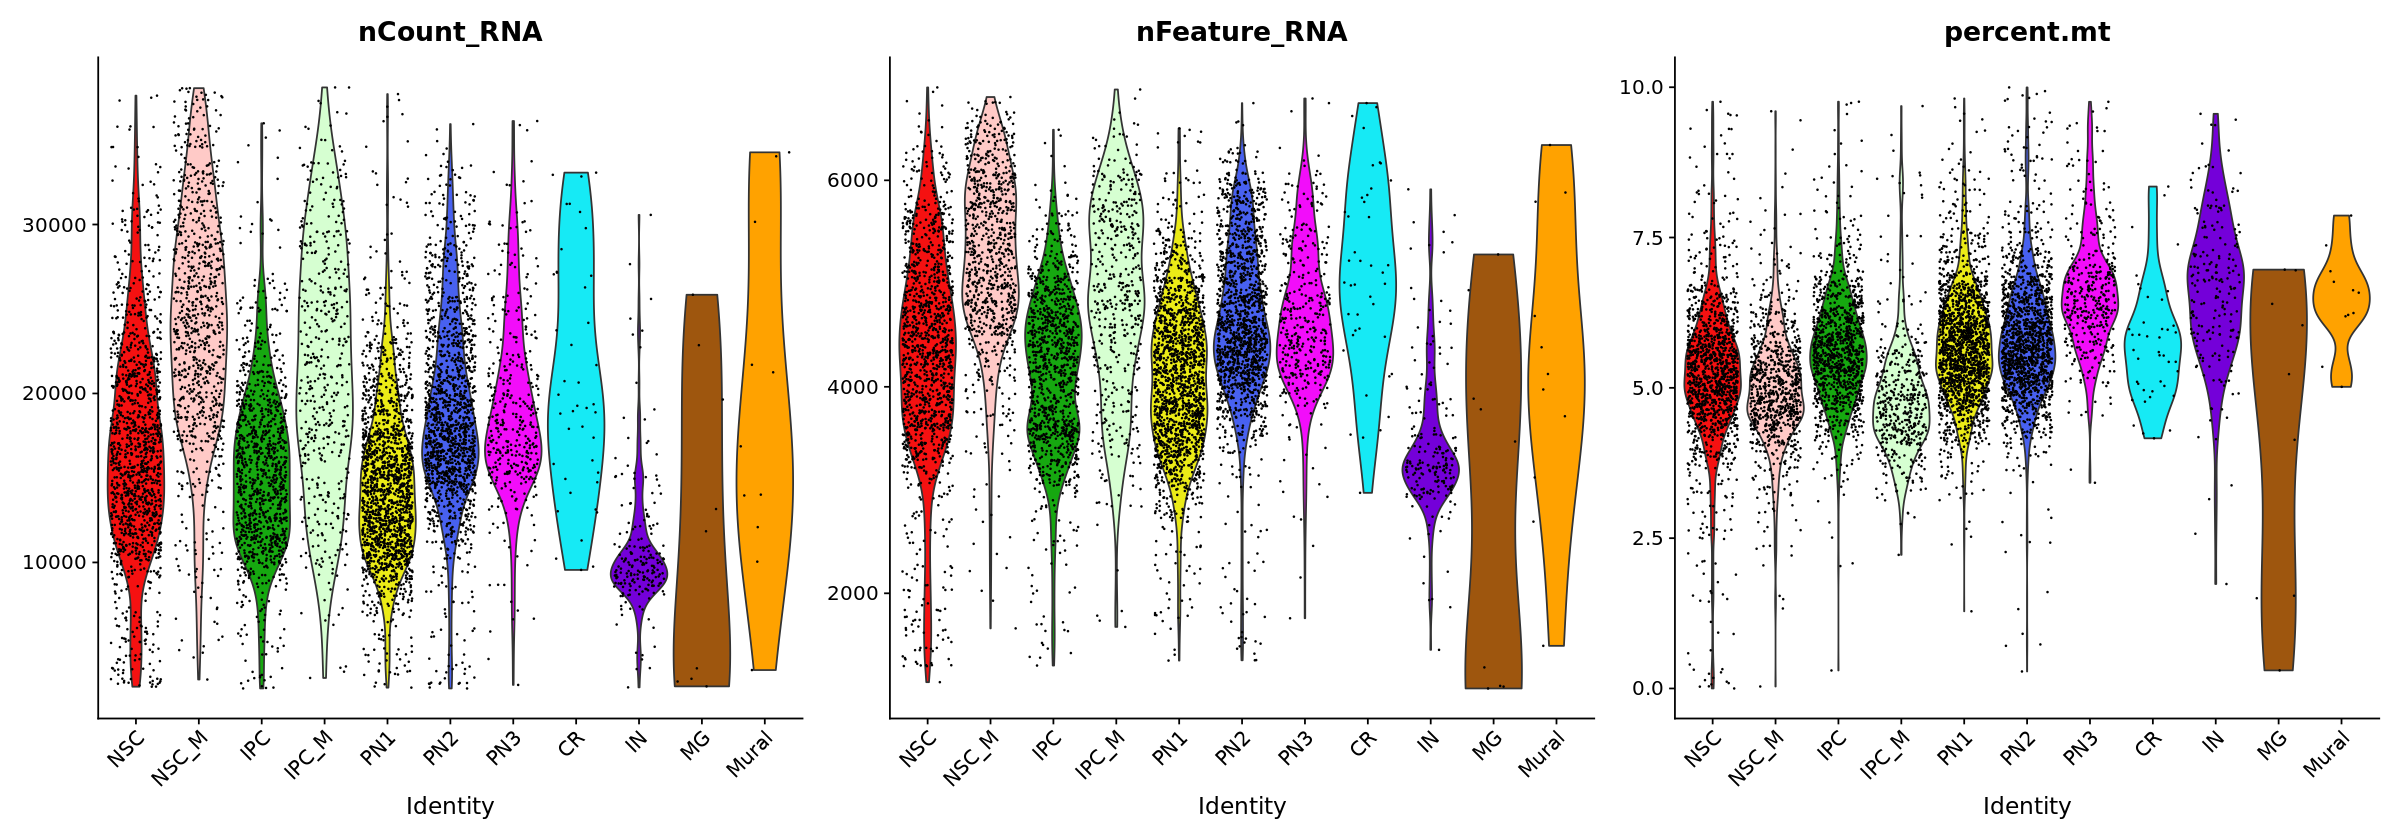

In [10]:
rna$annotation_id <- Idents(rna)
rna$annotation <- as.character(rna$annotation_id)
VlnPlot(rna, group.by = 'annotation_id', features=c('nCount_RNA','nFeature_RNA', 'percent.mt'), cols=RNA_cluster_colors)

In [15]:
rna$selected <- rna$annotation_id %in% selected_ids

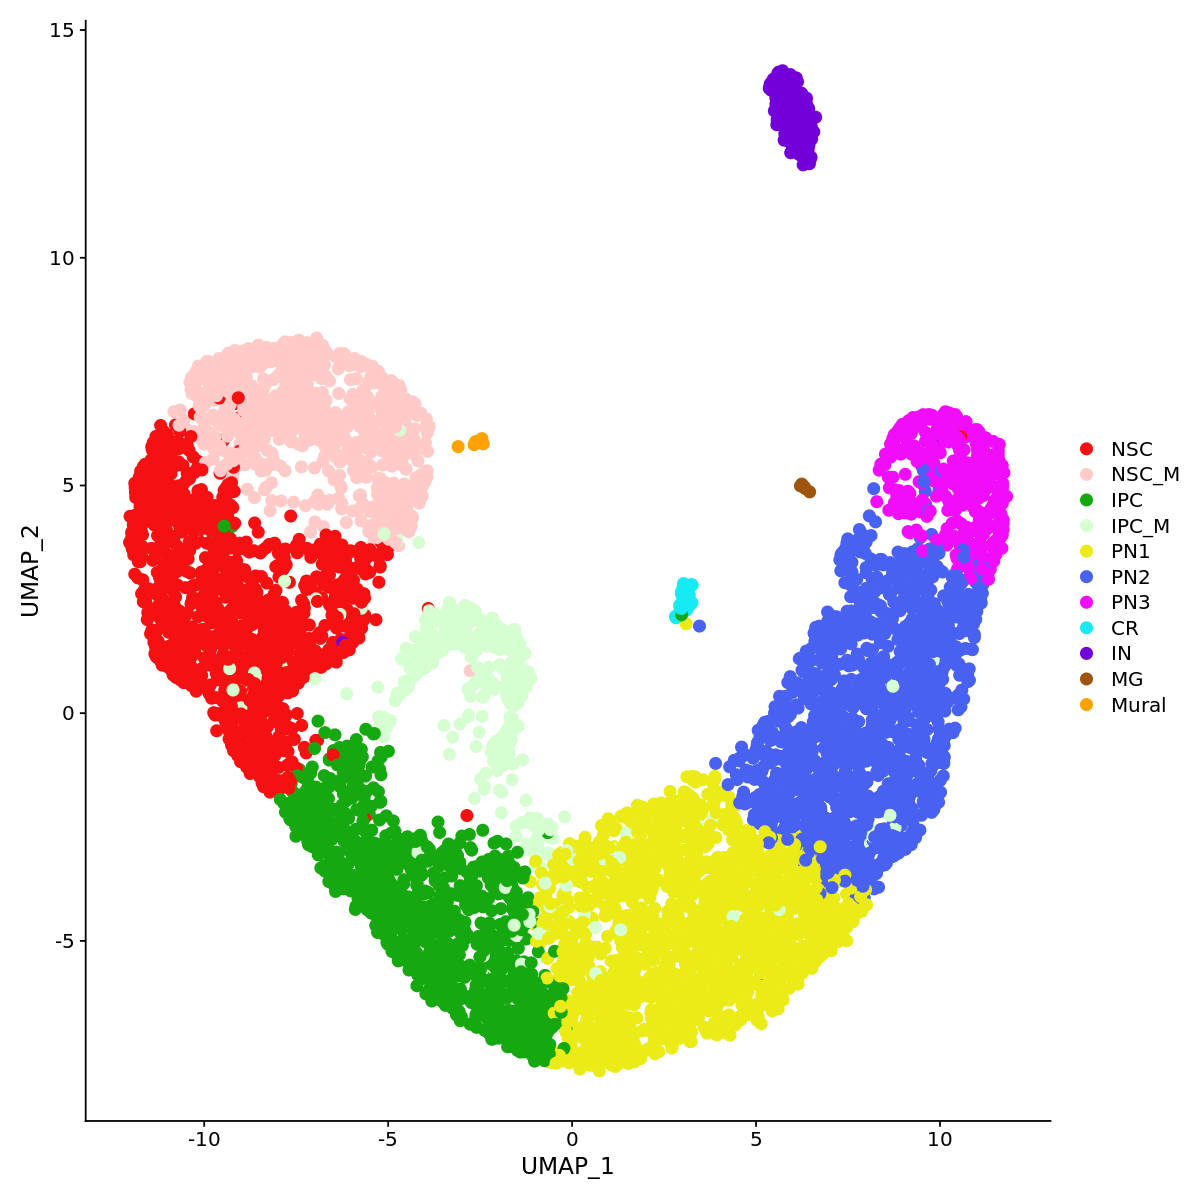

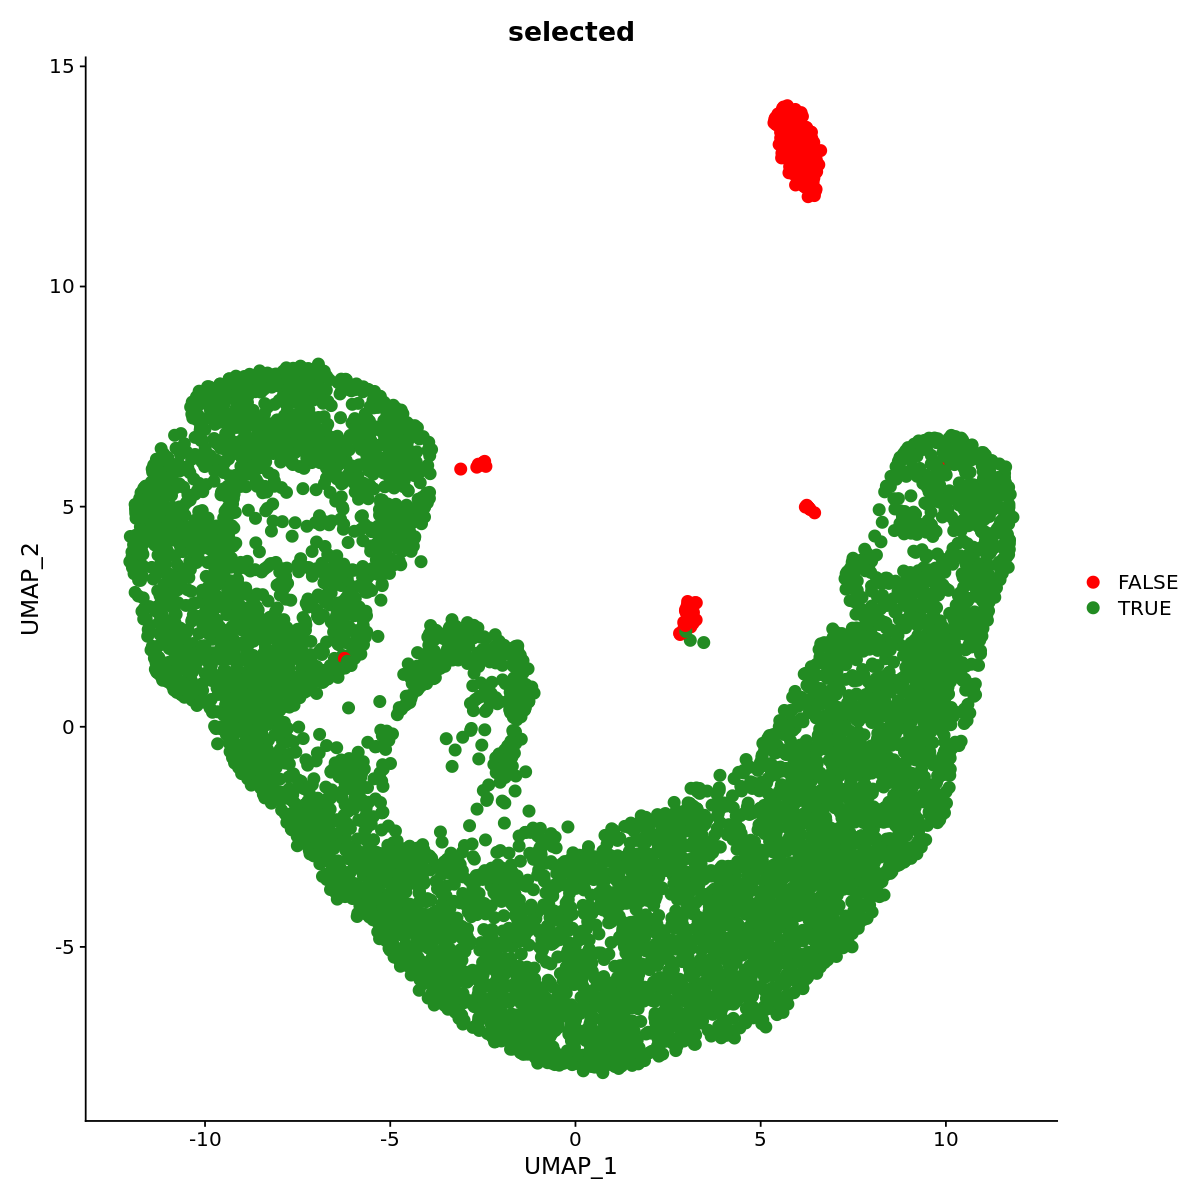

In [24]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(rna, pt.size = 3, cols=RNA_cluster_colors)
DimPlot(rna, group.by='selected',pt.size = 3, cols=c('red', 'forestgreen'))

In [8]:
table(rna$annotation)


   CR    IN   IPC IPC_M    MG Mural   NSC NSC_M   PN1   PN2   PN3 
   42   200  1075   452     9    11  1255   845  1712  1489   379 

In [9]:
palette <- setNames(RNA_cluster_colors, levels(rna$annotation))

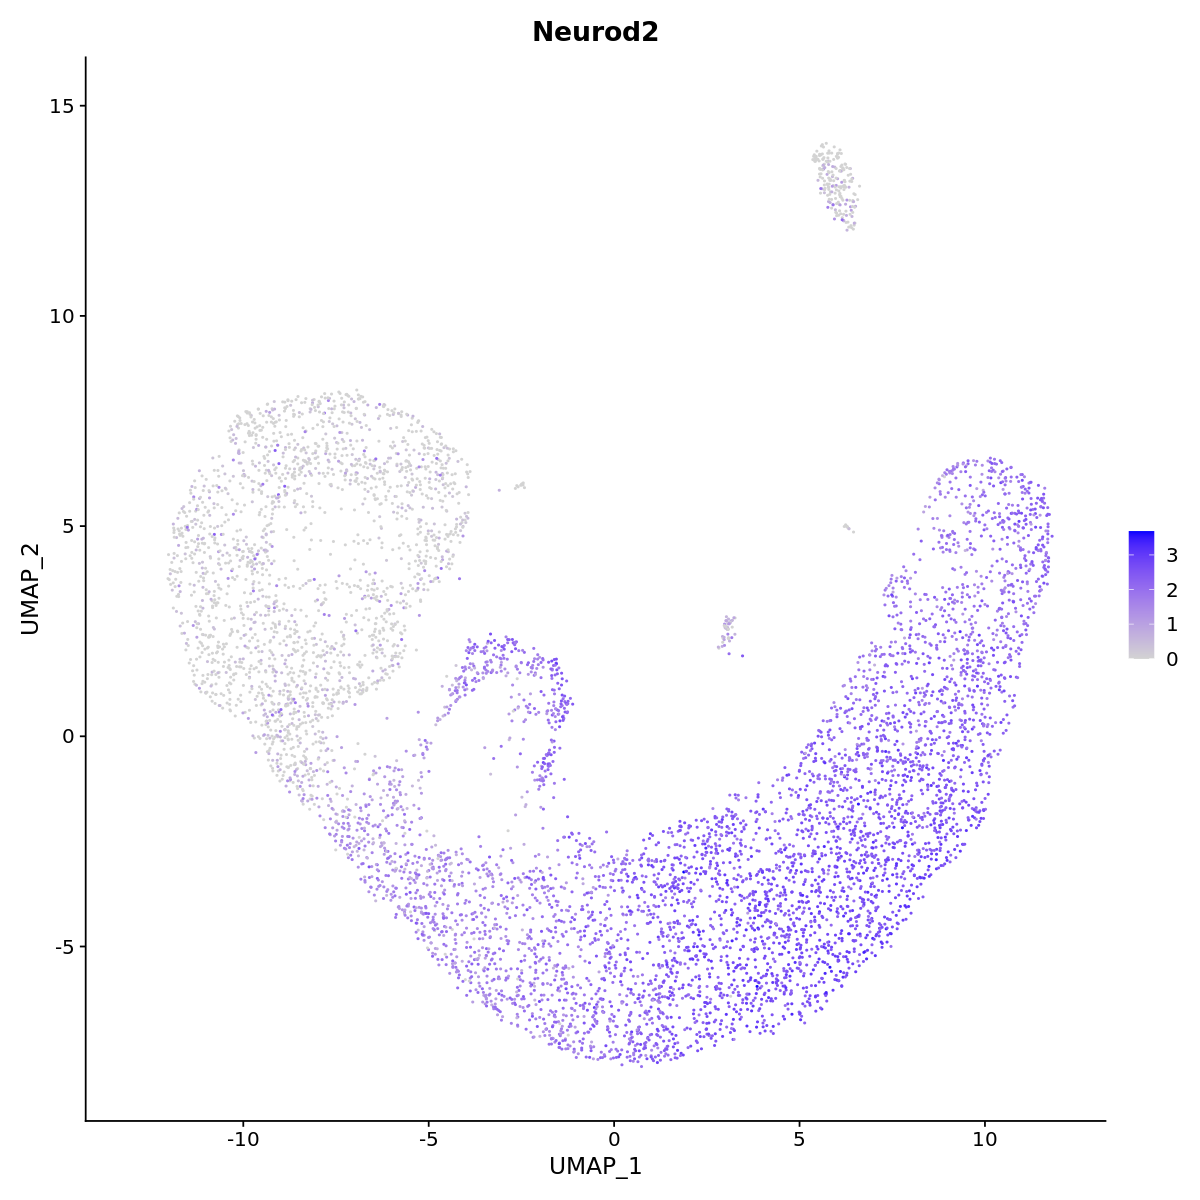

In [12]:
FeaturePlot(rna, 'Neurod2')

In [26]:
saveRDS(rna, '~/codebases/share/Noack_for_Carlo.merged_scRNA_unfiltered_IDs.rds')

### Export scRNA-Seq to anndata


In [38]:
rna <- subset(rna, annotation %in% selected_ids)

In [39]:
rna[['counts']] <- CreateAssayObject(data = rna[['RNA']]@counts, min.cells = 0, min.features = 0)

In [40]:
rna[['RNA']] 

Assay data with 18008 features for 7207 cells
Top 10 variable features:
 Reln, Hist1h2ap, Sst, Ube2c, Hist1h1b, Cenpf, Npy, Calb2, Fabp7, Top2a 

In [41]:
interm.file <-  "/scratch/rna.h5Seurat"
h5ad.file <- file.path(dirname(interm.file), 'rna.h5ad')
final.file <- '../raw/xabier/merged_scRNA_unfiltered_IDs.selected_celltypes.h5ad'

SeuratDisk::SaveH5Seurat(rna, filename = interm.file, verbose=T, overwrite=T)
SeuratDisk::Convert(interm.file, dest = "h5ad")


Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding data for counts

No variable features found for counts

No feature-level metadata found for counts

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Adding cell embeddings for harmony

No loadings for harmony

No projected loadings for harmony

No standard deviations for harmony

No JackStraw data for harmony

Validating h5Seurat file

Adding scale.data from RNA as X

Transfering meta.features to var

Adding data from RNA as raw

Transfering meta.features to raw/var

Transfering meta.data to obs

Adding dimensional reduction information for harmo

In [ ]:
save

In [42]:
file.copy(from = h5ad.file,
          to = final.file,
          overwrite = T)

[1] TRUE

In [43]:
file.remove(interm.file)
file.remove(h5ad.file)

[1] TRUE

[1] TRUE

In [29]:
list.files(dirname(interm.file))

[1] "bck"           "NeuralPCW20"   "RGCmaturation" "xoel"